- EDA
- Yilin Sun
- 20190325

### 1. Basic Info

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from scipy.linalg import svd

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('vanguard_merge.csv')

# remove blanks from column names
df.columns = df.columns.str.strip().str.replace('-', '').str.replace(' ','')

print('The dimension of dataset is', df.shape)

The dimension of dataset is (1541005, 27)


In [3]:
df.head()

,BCLASS3,Country,BidSpread,CurYld,GSpd,YearstoMat,OAS,OAD,AmtOut,Cpn,...,KRD2Y,KRD5Y,KRD10Y,KRD20Y,KRD30Y,S&PRatingNum,AccruedInt(%),YieldtoMat,ClassDetailCode,date
0,Capital Goods,Switzerland,27.0,2.88,34.0,4.20,33.65,3.91,1250000.0,2.875,...,1.06,2.86,0.00,0.00,0.00,7.0,0.870,2.88,BBBK,2018-02-26
1,Capital Goods,Switzerland,103.0,4.26,107.0,24.20,108.01,15.04,750000.0,4.375,...,0.06,0.23,0.75,8.52,5.47,7.0,1.325,4.19,BBBK,2018-02-26
2,Insurance,United States,74.0,3.87,60.0,3.97,59.67,3.68,350000.0,4.000,...,1.29,2.38,0.00,0.00,0.00,8.0,0.133,3.11,BAGA,2018-02-26
3,Insurance,United States,59.0,3.55,54.0,5.30,53.56,4.80,700000.0,3.625,...,0.05,4.46,0.28,0.00,0.00,8.0,0.725,3.20,BAGA,2018-02-26
4,Insurance,United States,82.0,3.58,66.0,6.72,65.13,5.92,750000.0,3.625,...,0.04,3.88,1.99,0.00,0.00,8.0,1.027,3.42,BAGA,2018-02-26


##### Missing values pattern by column

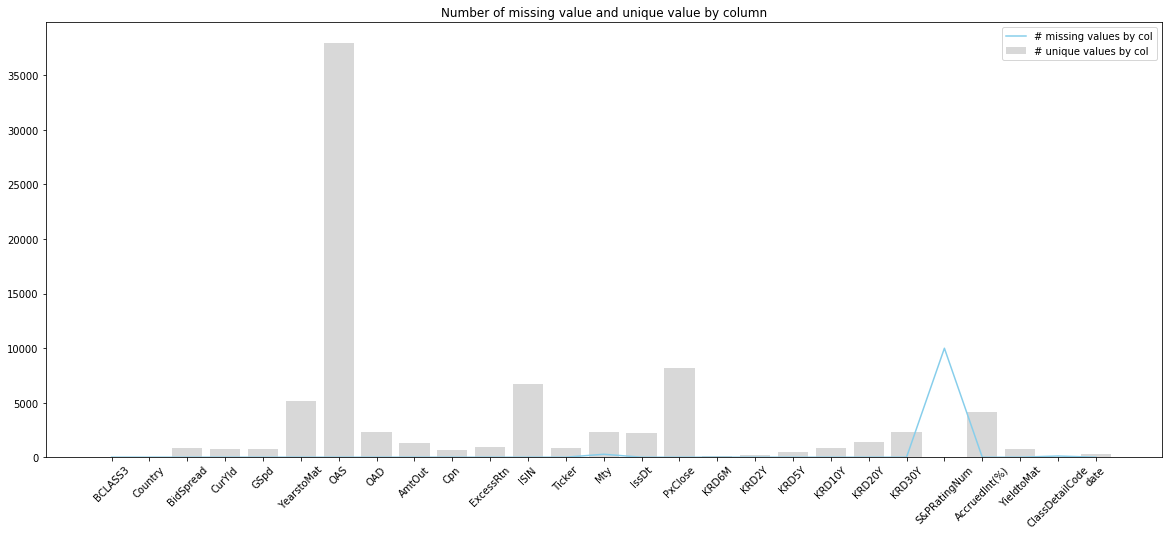

In [4]:
colnames = list(df.columns.values)
nunique = df.nunique()
nan = df.isnull().sum()

# plot
plt.figure(figsize=(20,8))
plt.bar(list(range(len(colnames))), nunique, label = '# unique values by col', color='grey', alpha=.3)
plt.plot(list(range(len(colnames))), nan, label = '# missing values by col', color='skyblue')
plt.title('Number of missing value and unique value by column')
plt.xticks(list(range(len(colnames))), colnames, rotation = 45)
plt.legend()

plt.savefig('eda-elin-missing-value-and-unique-value-by-column.jpg')

plt.show()

##### 3 columns have missing values: _Mty_, _S&P Rating Num_, _Class - Detail - Code_ 

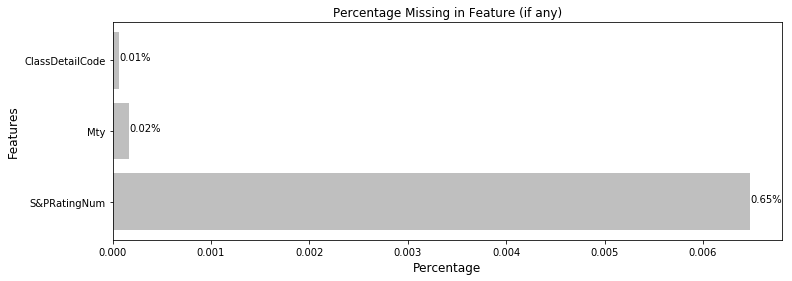

In [5]:
# check percentage missing in each feature if there is any
num_miss = df.isnull().sum().sort_values(ascending=False)
perc_miss = round(num_miss.loc[num_miss != 0]/df.shape[0], 5)

# visualize missing patterns
plt.figure(figsize=(12,4))
plt.barh(perc_miss.index, perc_miss.values, align='center', alpha=0.5, color='grey')
plt.title('Percentage Missing in Feature (if any)')
plt.xlabel('Percentage', fontsize=12)
plt.ylabel('Features', fontsize=12)
for i in range(len(perc_miss.index)):
    plt.text(perc_miss.values[i], perc_miss.index[i], str(round(perc_miss.values[i]*100,2))+'%')
    
plt.savefig('eda-elin-missing-percent.jpg')
plt.show()

In [6]:
num_miss.loc[num_miss != 0]/df.shape[0]

S&PRatingNum       0.006480
Mty                0.000174
ClassDetailCode    0.000068
dtype: float64

##### Missing G-spread for each bond

In [7]:
print('There are %d bonds in our dataset.' % df.ISIN.nunique())

There are 6739 bonds in our dataset.


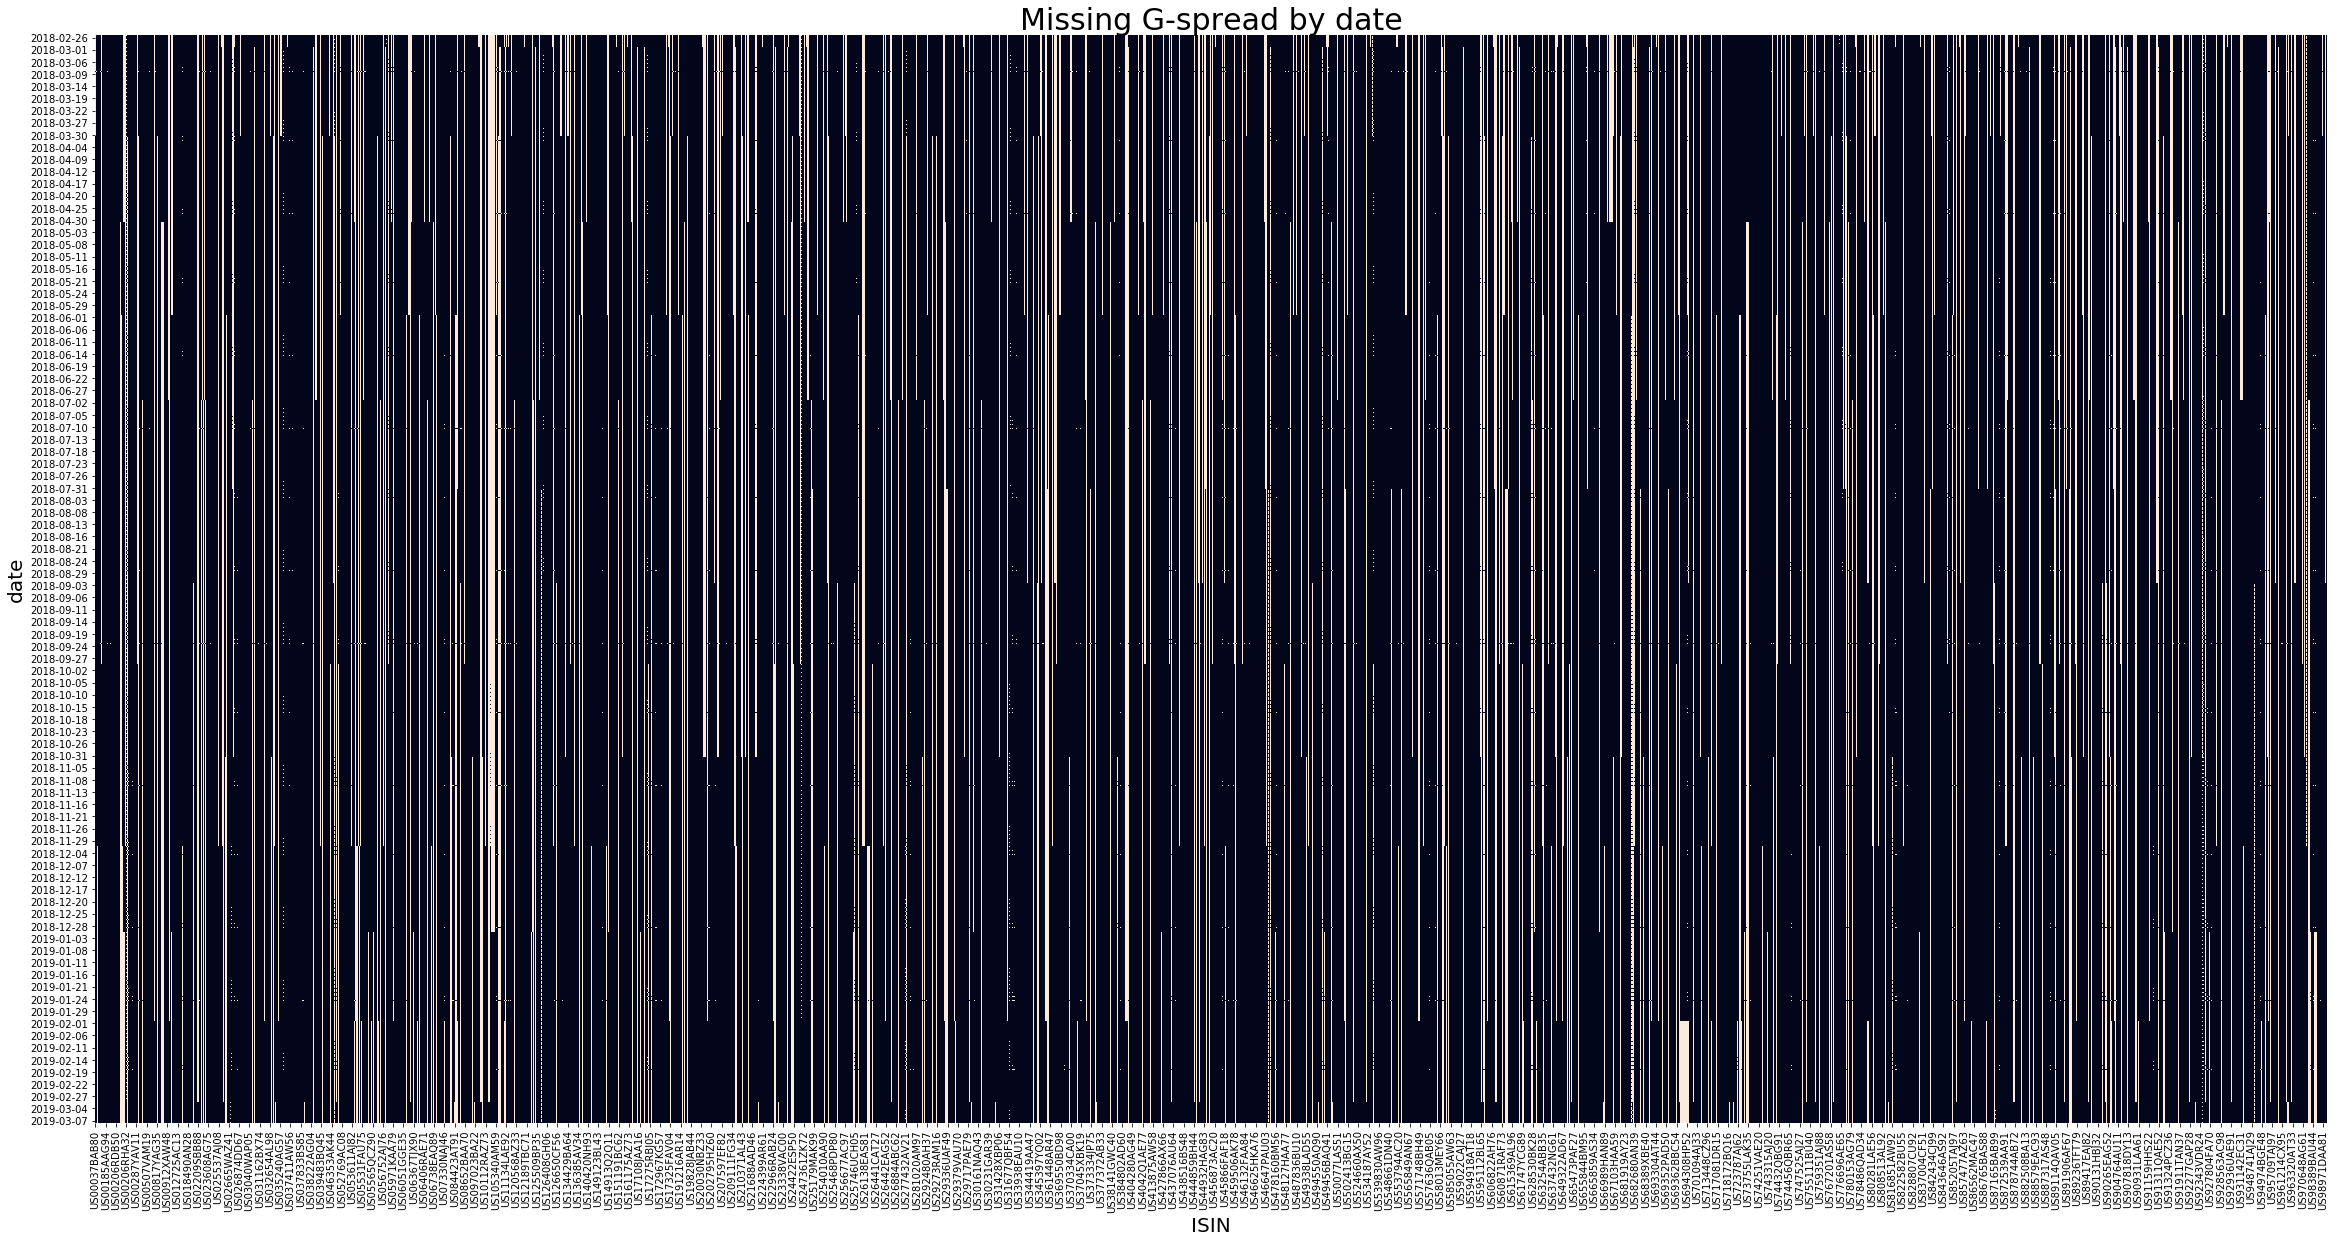

In [8]:
# check if all bonds are active from 2018-02-26 to 2019-03-07
# convert dataframe to pivot table, rows are dates and columns are unique bonds
date_bond = df.pivot(index = 'date', columns = 'ISIN', values = 'GSpd')

plt.figure(figsize=(40, 20))
plt.title('Missing G-spread by date', fontsize = 30)
plt.xlabel('Bond ISIN', fontsize = 20)
plt.ylabel('Date', fontsize = 20)
sns.heatmap(date_bond.isnull(), cbar=False)

Explanation: if a bond's rating was changed for some time, the information of this bond for this time period is removed from our dataset (consult Jeff for more details.)

### 2. Aggregate info

##### Country-wise: how many unique issuers and bonds does each country have? and the amount outstanding?

In [9]:
df = df.sort_values(by = 'Country')
countries = df.Country.drop_duplicates().values
num_issuer_per_country = df[['Country', 'Ticker']].drop_duplicates().groupby('Country').count().values.flatten()
num_bonds_per_country = df[['Country', 'ISIN']].drop_duplicates().groupby('Country').count().values.flatten()
amount_outstanding_per_country = df[['Country', 'ISIN', 
                                     'AmtOut']].drop_duplicates().groupby('Country').sum().values.flatten()/10e5

In [10]:
print(countries)
countries[-2] = 'UK'

['Australia' 'Belgium' 'Bermuda' 'Brazil' 'Canada' 'Chile' 'China'
 'Colombia' 'France' 'Germany' 'Ireland' 'Italy' 'Japan' 'Luxembourg'
 'Macau' 'Mexico' 'Netherlands' 'S.Africa' 'S.Korea' 'Singapore' 'Spain'
 'Sweden' 'Switzerland' 'United Kingdom' 'United States']


In [11]:
# the last number is U.S
num_bonds_per_country

array([  70,    1,    4,   20,  249,    9,   21,    1,   37,   24,   16,
          2,  128,    7,    6,   26,   74,    3,    1,    3,   20,   13,
         34,  216, 5765])

In [12]:
# the last number is U.S
num_issuer_per_country

array([  7,   1,   3,   6,  37,   5,   3,   1,   9,   3,   1,   2,   9,
         1,   1,   5,   9,   1,   1,   1,   4,   2,   5,  23, 689])

In [13]:
# amount outstanding
amount_outstanding_per_country

array([6.89132150e+01, 8.26888000e-01, 1.45000000e+00, 2.86848670e+01,
       1.91960445e+02, 7.91139300e+00, 2.24715290e+01, 9.95643000e-01,
       4.04105070e+01, 4.18038170e+01, 1.18496040e+01, 2.05576000e+00,
       1.39758399e+02, 6.85530800e+00, 1.10000000e+01, 2.26930720e+01,
       8.78205600e+01, 3.25000000e+00, 5.00000000e-01, 1.60000000e+00,
       2.46500000e+01, 1.39000000e+01, 5.20460120e+01, 2.86070659e+02,
       5.26255060e+03])

In [14]:
countries[-2] = 'UK'
countries

array(['Australia', 'Belgium', 'Bermuda', 'Brazil', 'Canada', 'Chile',
       'China', 'Colombia', 'France', 'Germany', 'Ireland', 'Italy',
       'Japan', 'Luxembourg', 'Macau', 'Mexico', 'Netherlands',
       'S.Africa', 'S.Korea', 'Singapore', 'Spain', 'Sweden',
       'Switzerland', 'UK', 'United States'], dtype=object)

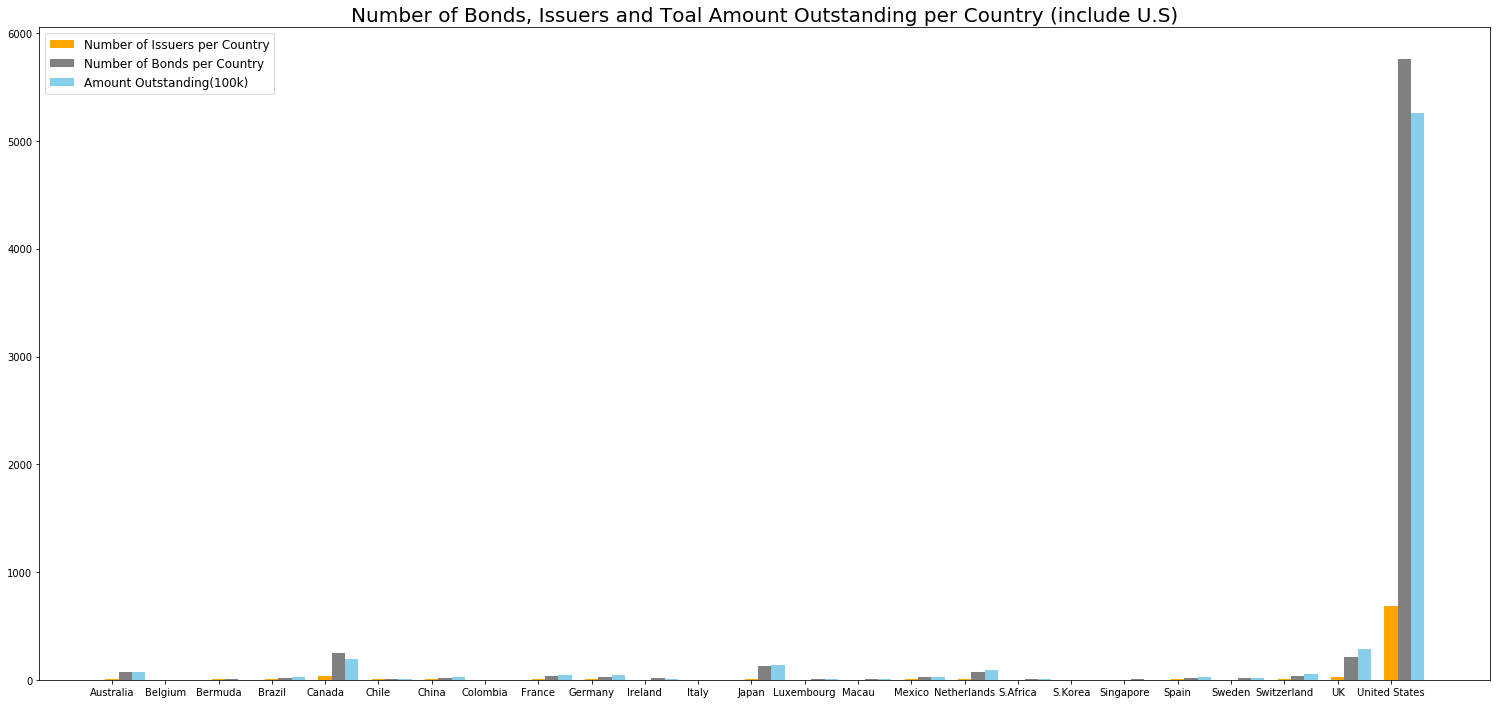

In [15]:
plt.figure(figsize=(26,12))

barWidth = .25
r1 = list(range(len(countries)))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.bar(r1, num_issuer_per_country, width = barWidth, color = 'orange', label = 'Number of Issuers per Country')
plt.bar(r2, num_bonds_per_country, width = barWidth, color = 'gray', label = 'Number of Bonds per Country' )
plt.bar(r3, amount_outstanding_per_country, width = barWidth, 
        color = 'skyblue', label = 'Amount Outstanding(100k)' )

plt.title('Number of Bonds, Issuers and Toal Amount Outstanding per Country (include U.S)', fontsize = 20)
plt.xticks(list(range(len(countries))), countries, fontsize = 10)
plt.legend(fontsize = 12)

plt.savefig('eda-elin-overview.jpg')

plt.show()

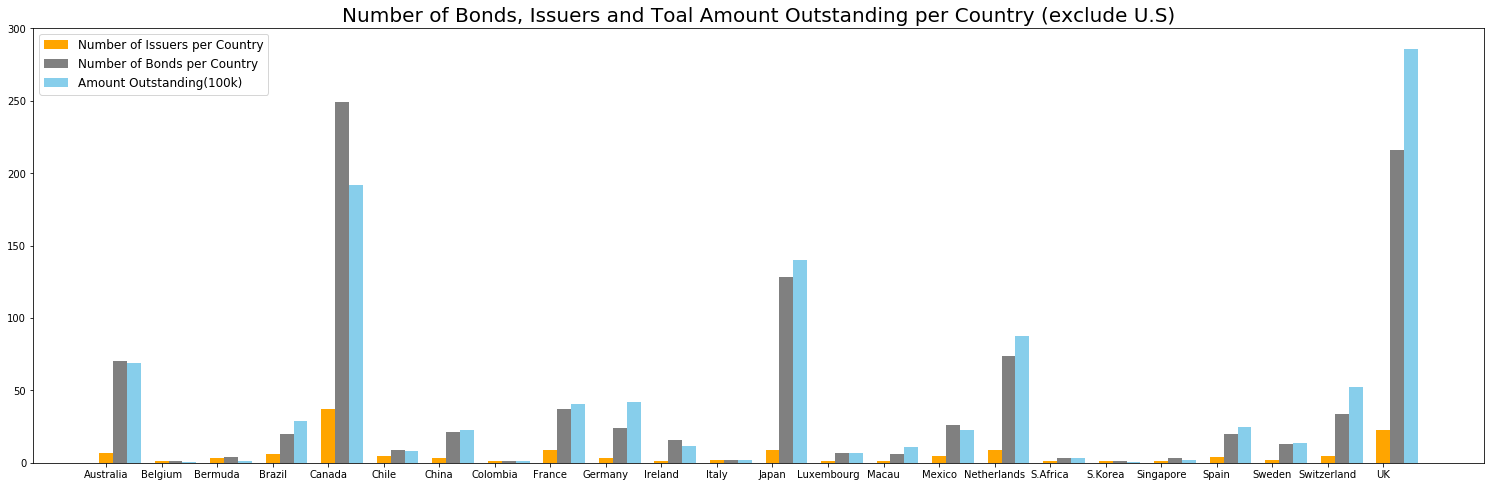

In [16]:
plt.figure(figsize=(26,8))

barWidth = .25
r1 = list(range(len(countries)-1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.bar(r1, num_issuer_per_country[:-1], width = barWidth, color = 'orange', label = 'Number of Issuers per Country')
plt.bar(r2, num_bonds_per_country[:-1], width = barWidth, color = 'gray', label = 'Number of Bonds per Country' )
plt.bar(r3, amount_outstanding_per_country[:-1], width = barWidth, 
        color = 'skyblue', label = 'Amount Outstanding(100k)' )

plt.title('Number of Bonds, Issuers and Toal Amount Outstanding per Country (exclude U.S)', fontsize = 20)
plt.xticks(list(range(len(countries)-1)), countries[:-1], fontsize = 10)
plt.legend(fontsize = 12)

plt.savefig('eda-elin-overview-noUS.jpg')
plt.show()

### 2. Bonds Correlation by Sector: pairwise correlations between G-spread

In [17]:
print('There are %d sectors in the dataset.' % df.BCLASS3.nunique())

There are 19 sectors in the dataset.


In [18]:
sectors = np.unique(df.BCLASS3)

In [19]:
# take one sector as an example to plot the correlation matrix
bonds = df.loc[df.BCLASS3 == sectors[0]][['GSpd', 'ISIN', 'BCLASS3', 'date']]
corrcoef = bonds.pivot(index = 'date', columns = 'ISIN', values = 'GSpd').corr()

bonds.head()

,GSpd,ISIN,BCLASS3,date
1164900,94.0,US63254AAY47,Banking,2018-12-06
1164899,72.0,US63254AAX63,Banking,2018-12-06
1164898,88.0,US63254AAW80,Banking,2018-12-06
1164897,64.0,US63254AAV08,Banking,2018-12-06
1164896,82.0,US63254AAU25,Banking,2018-12-06


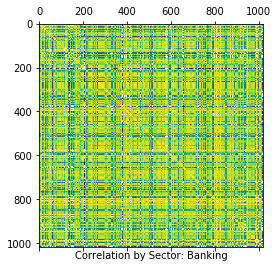

In [20]:
# plot coef matrix
plt.matshow(corrcoef)
plt.xlabel('Correlation by Sector: ' + sectors[0])
plt.show()

In [21]:
# define a function to calculate quantiles for one sector
def sector_coef(ind):
    # select one sector 
    thisSector = sectors[ind]
    bonds = df.loc[df.BCLASS3 == thisSector][['GSpd', 'ISIN', 'BCLASS3', 'date']]
    
    # convert rows of records to pivot table and get correlation coefficient matrix
    corrcoef = bonds.pivot(index = 'date', columns = 'ISIN', values = 'GSpd').corr()
    
    # extract upper triangle of coef matrix
    coef = np.triu(corrcoef,1).flatten()
    
    # remove NAs
    coef = coef[~np.isnan(coef)]
    
    # calculate quantiles and return
    return coef #np.quantile(coef, [0, .25, .5, .75, 1]) 

In [22]:
# calculate quantiles for all sectors
sector_names = []
sector_corrcoef = []
for onesector in range(df.BCLASS3.nunique()):
    
    # calculate quantiles
    coef = sector_coef(onesector)
    
    # append this sector and quantiles
    sector_names.append(sectors[onesector])
    sector_corrcoef.append(coef)

In [23]:
sector_names[10] = 'Gov Owned, No Guarantee'
sector_names[2] = 'Brokerage Assetmanagers EXC'

In [24]:
sector_names

['Banking',
 'Basic Industry',
 'Brokerage Assetmanagers EXC',
 'Capital Goods',
 'Communications',
 'Consumer Cyclical',
 'Consumer Non-Cyclical',
 'Electric',
 'Energy',
 'Finance Companies',
 'Gov Owned, No Guarantee',
 'Insurance',
 'Natural Gas',
 'Other Financial',
 'Other Industrial',
 'Other Utility',
 'REITs',
 'Technology',
 'Transportation']

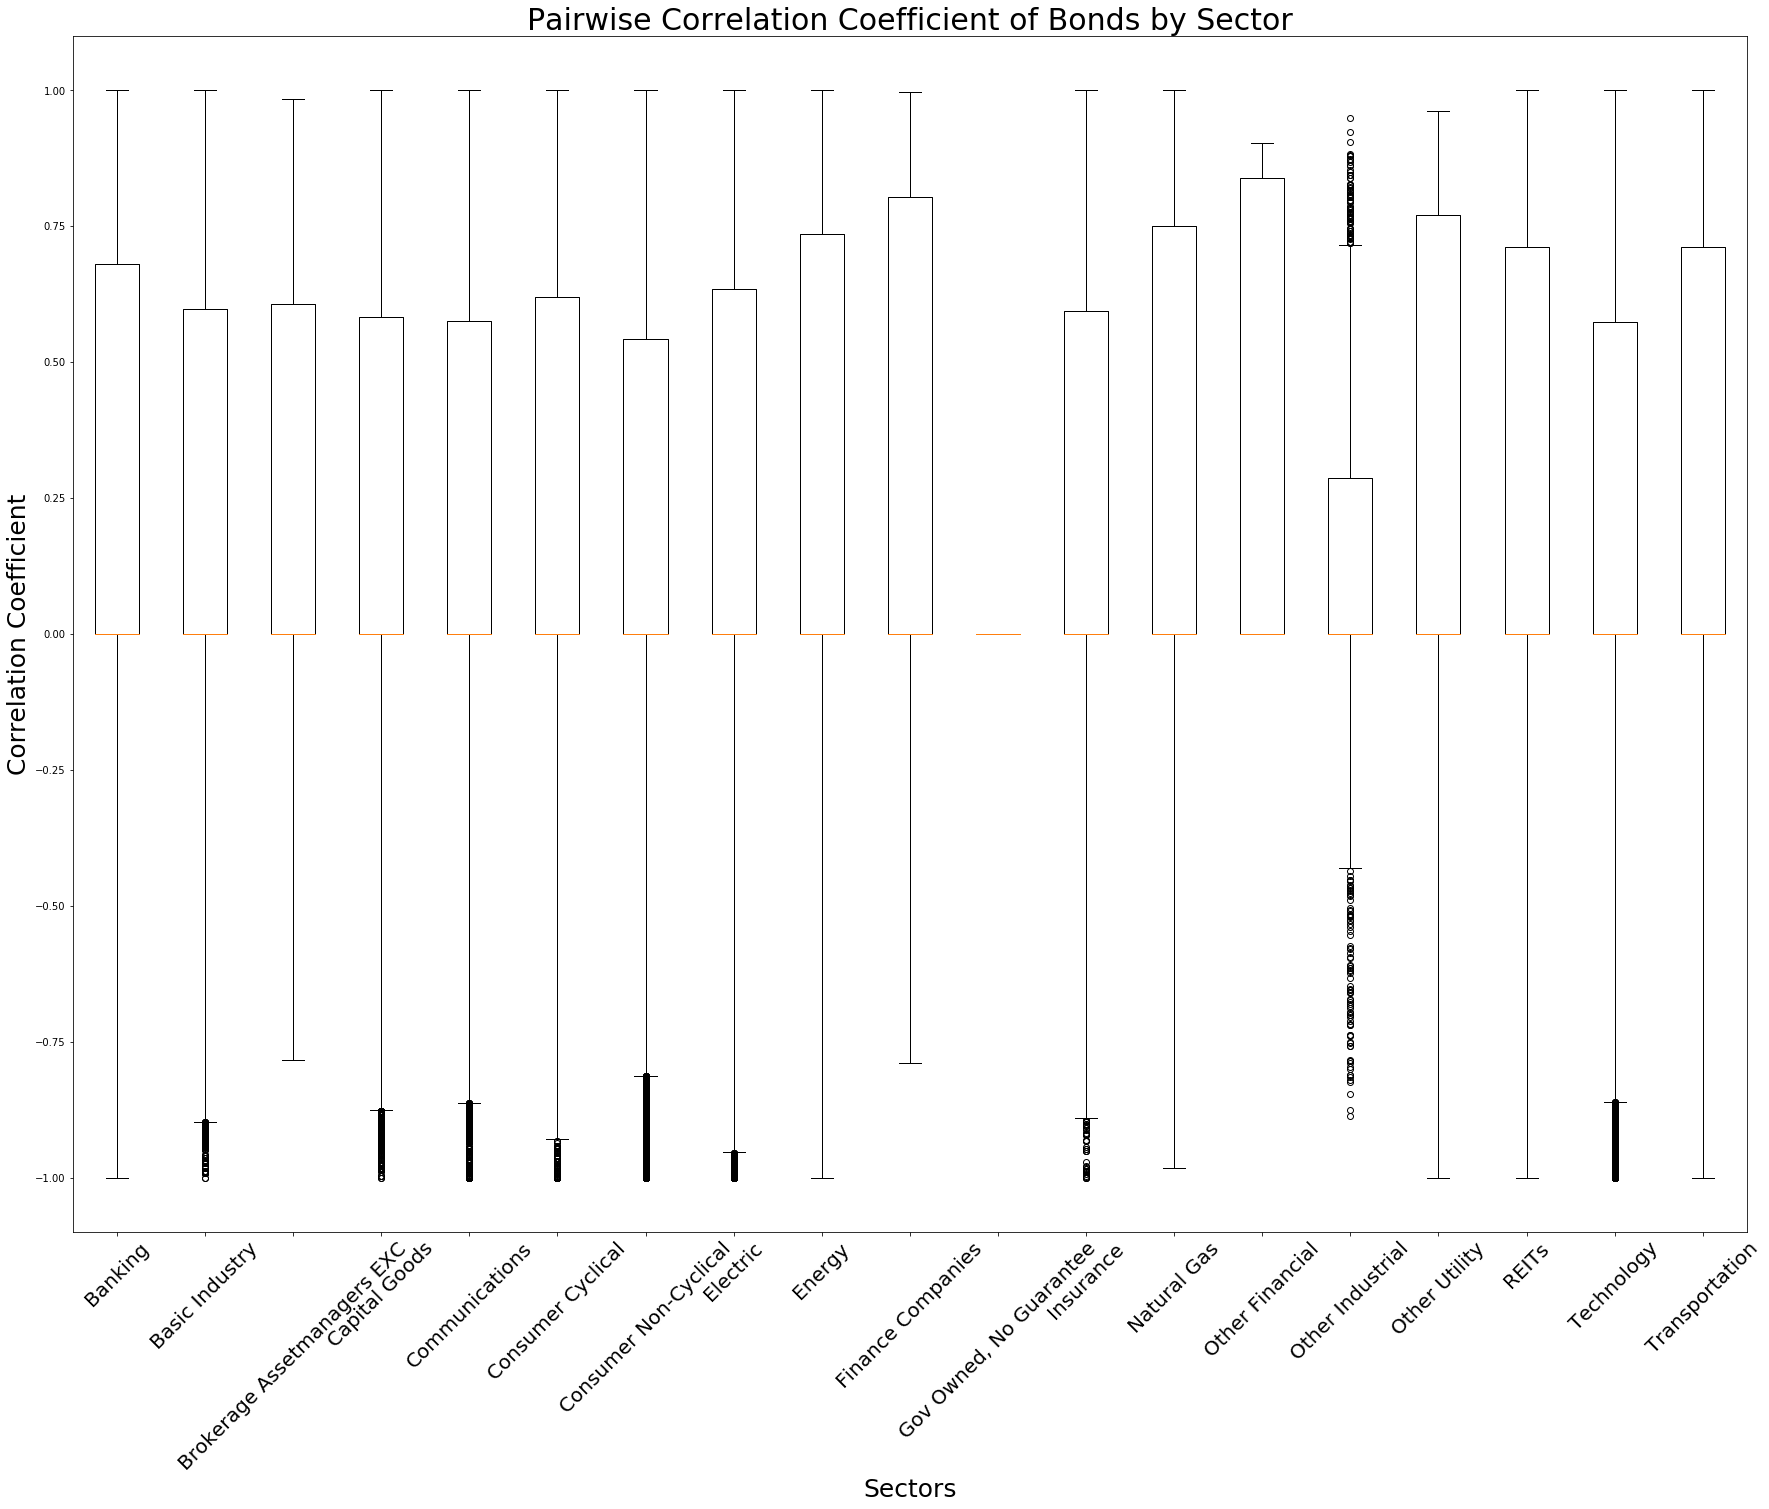

In [25]:
# boxplot
fig, ax = plt.subplots(figsize = (30, 22))
ax.set_title('Pairwise Correlation Coefficient of Bonds by Sector', fontsize=30)
ax.boxplot(sector_corrcoef)
plt.xticks(list(range(1, len(sector_names)+1)), sector_names, fontsize = 20, rotation = 45)
plt.xlabel('Sectors', fontsize = 25)
plt.ylabel('Correlation Coefficient', fontsize = 25)

plt.savefig('eda-elin-pairwise-correlation-by-sector.jpg')
plt.show()

### 3. Bonds Correlation by Country: pairwise correlation between G-spread

In [26]:
print('There are %d sectors in the dataset.' % df.Country.nunique())

There are 25 sectors in the dataset.


In [27]:
countries = np.unique(df.Country)

In [28]:
# define a function to calculate quantiles for one country
def country_coef(ind):
    # select one sector 
    thisCountry = countries[ind]
    bonds = df.loc[df.Country == thisCountry][['GSpd', 'ISIN', 'Country', 'date']]
    
    # convert rows of records to pivot table and get correlation coefficient matrix
    corrcoef = bonds.pivot(index = 'date', columns = 'ISIN', values = 'GSpd').corr()
    
    # extract upper triangle of coef matrix
    coef = np.triu(corrcoef,1).flatten()
    
    # remove NAs
    coef = coef[~np.isnan(coef)]
    
    # calculate quantiles and return
    return coef #np.quantile(coef, [0, .25, .5, .75, 1]) 

In [29]:
# calculate quantiles for all countries
country_names = []
country_corrcoef = []
for onecountry in range(df.Country.nunique()):
    
    # calculate quantiles
    coef = country_coef(onecountry)
    
    # append this sector and quantiles
    country_names.append(countries[onecountry])
    country_corrcoef.append(coef)

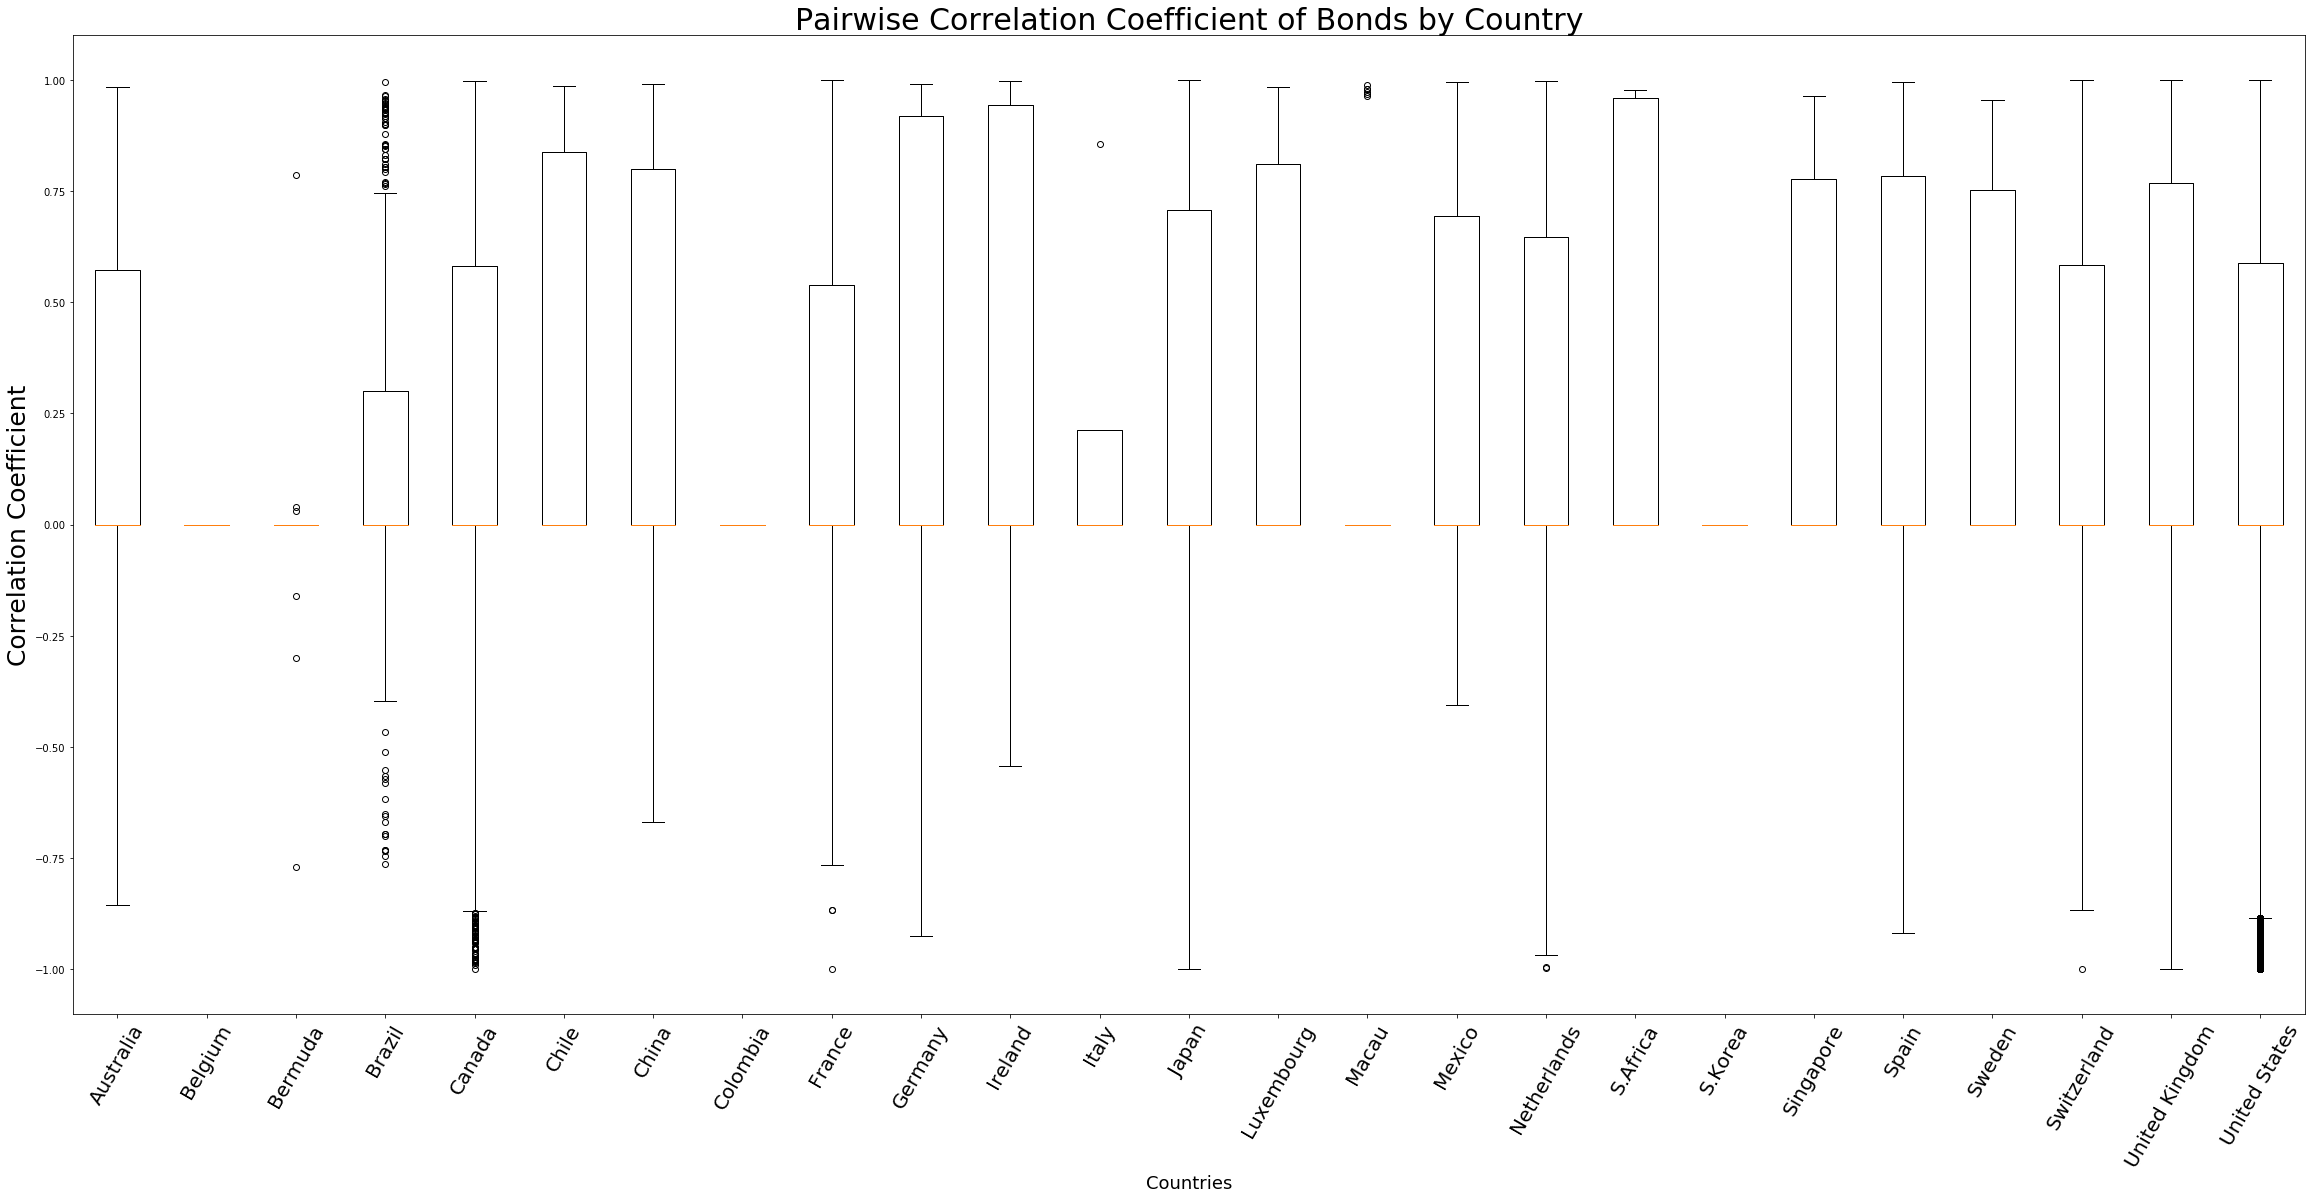

In [30]:
# boxplot
fig, ax = plt.subplots(figsize = (40, 18))
ax.set_title('Pairwise Correlation Coefficient of Bonds by Country', fontsize=30)
ax.boxplot(country_corrcoef)
plt.xticks(list(range(1, len(country_names)+1)), country_names, fontsize = 20, rotation = 60)
plt.xlabel('Countries', fontsize = 18)
plt.ylabel('Correlation Coefficient', fontsize = 25)

plt.savefig('eda-elin-pairwise-correlation-by-country.jpg')
plt.show()